In [2]:
import pandas as pd
import tarfile
import tqdm
import cv2, os

In [3]:
# http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
ATTRS_NAME = "/media/mitu/data/datasets/lfw_attributes.txt"

# http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
IMAGES_NAME = "/media/mitu/data/datasets/lfw-deepfunneled.tgz"

# http://vis-www.cs.umass.edu/lfw/lfw.tgz
RAW_IMAGES_NAME = "/media/mitu/data/datasets/lfw.tgz"

In [4]:
def decode_image_from_raw_bytes(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [6]:
def load_lfw_dataset(
        use_raw=False,
        dx=80, dy=80,
        dimx=45, dimy=45):

    # Read attrs
    df_attrs = pd.read_csv(ATTRS_NAME, sep='\t', skiprows=1)
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])
    imgs_with_attrs = set(map(tuple, df_attrs[["person", "imagenum"]].values))

    # Read photos
    all_photos = []
    photo_ids = []

    # tqdm in used to show progress bar while reading the data in a notebook here, you can change
    # tqdm_notebook to use it outside a notebook
    with tarfile.open(RAW_IMAGES_NAME if use_raw else IMAGES_NAME) as f:
        for m in tqdm.tqdm_notebook(f.getmembers()):
            # Only process image files from the compressed data
            if m.isfile() and m.name.endswith(".jpg"):
                # Prepare image
                img = decode_image_from_raw_bytes(f.extractfile(m).read())

                # Crop only faces and resize it
                img = img[dy:-dy, dx:-dx]
                img = cv2.resize(img, (dimx, dimy))

                # Parse person and append it to the collected data
                fname = os.path.split(m.name)[-1]
                fname_splitted = fname[:-4].replace('_', ' ').split()
                person_id = ' '.join(fname_splitted[:-1])
                photo_number = int(fname_splitted[-1])
                if (person_id, photo_number) in imgs_with_attrs:
                    all_photos.append(img)
                    photo_ids.append({'person': person_id, 'imagenum': photo_number})

    photo_ids = pd.DataFrame(photo_ids)
    all_photos = np.stack(all_photos).astype('uint8')

    # Preserve photo_ids order!
    all_attrs = photo_ids.merge(df_attrs, on=('person', 'imagenum')).drop(["person", "imagenum"], axis=1)

    return all_photos, all_attrs

In [7]:
import numpy as np
X, attr = load_lfw_dataset(use_raw=True, dimx=32, dimy=32)

<ipython-input-6-ca9b8ea3b148>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for m in tqdm.tqdm_notebook(f.getmembers()):


In [8]:
X = X.astype('float32') / 255.0 - 0.5

In [9]:
print(X.max(), X.min())

0.5 -0.5


In [10]:
import matplotlib.pyplot as plt
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))

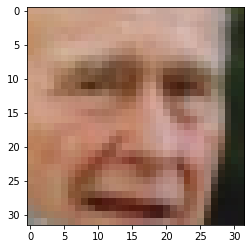

In [11]:
show_image(X[6])

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

In [13]:
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model

def build_autoencoder(img_shape, code_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())
    encoder.add(Dense(code_size))

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(np.prod(img_shape))) # np.prod(img_shape) is the same as 32*32*3, it's more generic than saying 3072
    decoder.add(Reshape(img_shape))

    return encoder, decoder

In [14]:
# Same as (32,32,3), we neglect the number of instances from shape
IMG_SHAPE = X.shape[1:]
encoder, decoder = build_autoencoder(IMG_SHAPE, 32)

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp,reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')

print(autoencoder.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 32)                98336     
                                                                 
 sequential_1 (Sequential)   (None, 32, 32, 3)         101376    
                                                                 
Total params: 199,712
Trainable params: 199,712
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
history = autoencoder.fit(x=X_train, y=X_train, epochs=50,
                validation_data=[X_test, X_test])

Epoch 1/50
370/370 [==============================] - 2s 6ms/step - loss: 0.0066 - val_loss: 0.0065
Epoch 2/50
370/370 [==============================] - 2s 6ms/step - loss: 0.0066 - val_loss: 0.0065
Epoch 3/50
370/370 [==============================] - 2s 6ms/step - loss: 0.0066 - val_loss: 0.0065
Epoch 4/50
370/370 [==============================] - 2s 5ms/step - loss: 0.0066 - val_loss: 0.0065
Epoch 5/50
370/370 [==============================] - 2s 5ms/step - loss: 0.0066 - val_loss: 0.0065
Epoch 6/50
370/370 [==============================] - 2s 5ms/step - loss: 0.0066 - val_loss: 0.0065
Epoch 7/50
370/370 [==============================] - 2s 5ms/step - loss: 0.0066 - val_loss: 0.0065
Epoch 8/50
370/370 [==============================] - 2s 5ms/step - loss: 0.0066 - val_loss: 0.0065
Epoch 9/50
370/370 [==============================] - 2s 5ms/step - loss: 0.0066 - val_loss: 0.0065
Epoch 10/50
370/370 [==============================] - 2s 5ms/step - loss: 0.0066 - val_loss: 0.0065

In [19]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    # img[None] will have shape of (1, 32, 32, 3) which is the same as the model input
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()

1/1 [==============================] - 0s 24ms/step


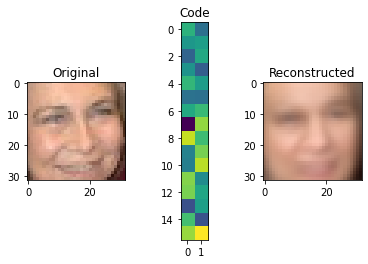

1/1 [==============================] - 0s 24ms/step


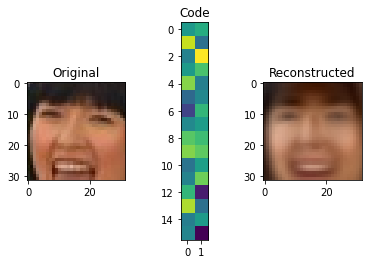

1/1 [==============================] - 0s 24ms/step


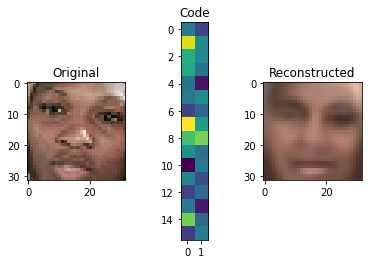

1/1 [==============================] - 0s 28ms/step


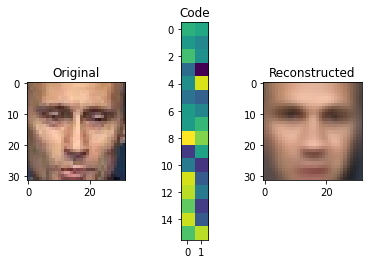

1/1 [==============================] - 0s 23ms/step


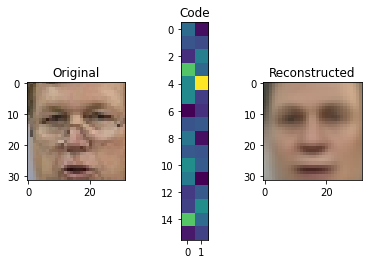

In [20]:
for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)